In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, TimeDistributed, Dropout
from keras import optimizers
from sklearn.metrics import mean_squared_error

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
tf.random.set_seed(42)

file_name = '/content/drive/My Drive/Colab Notebooks/extrusion.csv'

df = pd.read_csv(file_name)
df.info()

columns = df.columns.tolist()
print(columns)


print(df.shape)
print(np.shape(columns))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226536 entries, 0 to 226535
Columns: 470 entries, Datum to ST114_VARWdTensVis
dtypes: float64(469), object(1)
memory usage: 812.3+ MB
['Datum', 'ST0_VARActAuftrag', 'ST110_VARExtr_0_HeizungZone_3_Regler_Y', 'ST110_VARExtr_0_HeizungZone_3_SollTemp', 'ST110_VARExtr_0_HeizungZone_4_Konfig', 'ST110_VARExtr_0_HeizungZone_4_Regler_X', 'ST110_VARExtr_0_HeizungZone_4_Regler_Y', 'ST110_VARExtr_0_HeizungZone_4_SollTemp', 'ST110_VARExtr_0_HeizungZone_5_Konfig', 'ST110_VARExtr_0_HeizungZone_5_Regler_X', 'ST110_VARExtr_0_HeizungZone_5_Regler_Y', 'ST110_VARExtr_0_HeizungZone_5_SollTemp', 'ST110_VARExtr_0_HeizungZone_6_Konfig', 'ST110_VARExtr_0_HeizungZone_6_Regler_X', 'ST110_VARExtr_0_HeizungZone_6_Regler_Y', 'ST110_VARExtr_0_HeizungZone_6_SollTemp', 'ST110_VARExtr_0_HeizungZone_7_Konfig', 'ST110_VARExtr_0_HeizungZone_7_Regler_X', 'ST110_VARExtr_0_HeizungZone_7_Regler_Y', 'ST110_VARExtr_0_HeizungZone_7_SollTemp', 'ST110_VARExtr_0_HeizungZone_8_Konfig

In [3]:
del df['Datum']
columns.remove('Datum')

In [4]:
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min(axis = 0)) / (x_np.max(axis = 0) - x_np.min(axis = 0))

In [5]:
# target_index = columns.index('ST110_VAREx_0_SDickeIst') 
target_index = columns.index('ST110_VAREx_0_RegelungEin') 
print(target_index)

156


In [6]:
X = np.asarray(df)[:, :]
Y = np.asarray(df)[:, target_index]

print("X.shape: ", X.shape)
print("Y.shape: ", Y.shape)

X.shape:  (226536, 469)
Y.shape:  (226536,)


In [7]:
null_row = []

for i in range(len(X)):
    for j in range(len(columns)):
        if pd.isnull(X[i,j]):
            null_row.append(i)

In [8]:
null_row = sorted(list(set(null_row)))

print(null_row)
print(len(null_row))

[18398, 18399, 18400, 18454, 20979, 24019, 24035, 58210, 58211, 58212, 62021, 62022, 62023, 62024, 62025, 62026, 62027, 62028, 62029, 70978, 71524, 71576, 78210, 82932, 82933, 82934, 87052, 87053, 91158, 96208, 96209, 96210, 96211, 96212, 96213, 96214, 96215, 96216, 96217, 96218, 96219, 96220, 96221, 96222, 96223, 96224, 96225, 96226, 96227, 96228, 96229, 96230, 96231, 96232, 96233, 96234, 96235, 96236, 96237, 96238, 96239, 96240, 96241, 96242, 96243, 96244, 96245, 96246, 96247, 96248, 96249, 96250, 96251, 96252, 96253, 96254, 96255, 96256, 96257, 96258, 96259, 96260, 96261, 96262, 96263, 96264, 96265, 96266, 96267, 96268, 96269, 96270, 96271, 96272, 96273, 96274, 96275, 96276, 96277, 96278, 96279, 96280, 96281, 96282, 96283, 96284, 96285, 96286, 96287, 96288, 96289, 96290, 96291, 96292, 96293, 96294, 96295, 96296, 96297, 96298, 96299, 96300, 96301, 96302, 96303, 96304, 96305, 96306, 96307, 96308, 96309, 96310, 96311, 96312, 96313, 96314, 96315, 96316, 96317, 96318, 96319, 96320, 96321

In [9]:
seq_length = 50
predict_length = 10
input_columns = len(columns)

num_Data = 1

if null_row[0] - 1 > seq_length + predict_length:
    X0 = X[:null_row[0] - 1, :]
    Y0 = Y[:null_row[0] - 1]

for i in range(1, len(null_row)):
    if null_row[i] - null_row[i-1] - 1 > seq_length + predict_length:
        locals()['X{}'.format(num_Data)] = X[null_row[i-1] + 1 : null_row[i] - 1, :]
        locals()['Y{}'.format(num_Data)] = Y[null_row[i-1] + 1 : null_row[i] - 1]
        num_Data += 1

# for i in range(num_Data):
#     print('X{} -> '.format(i), 'The number of null value: ', pd.isnull(locals()['X{}'.format(i)]).sum().sum())
#     print('Y{} -> '.format(i), 'The number of null value: ', pd.isnull(locals()['Y{}'.format(i)]).sum().sum())

In [10]:
selected_feature_idx = [130, 156, 157, 253, 274, 278, 288, 465]
# selected_feature_idx = [36, 46, 130, 156, 157, 159, 253, 261, 274, 278, 288, 465, 468]
# selected_feature_idx = [111, 364, 435]

x = min_max_scaling(X0[:, selected_feature_idx])
y = min_max_scaling(Y0)

dataX = []
dataY = []
for i in range(0, len(y) - seq_length - predict_length + 1):
    _x = x[i : i + seq_length]
    _y = y[i + seq_length : i + seq_length + predict_length]
    dataX.append(_x)
    dataY.append(_y)

dataX = np.array(dataX)
dataY = np.array(dataY)

trainX, testX, trainY, testY = train_test_split(dataX, dataY, test_size=0.3, shuffle = False)
trainY = tf.expand_dims(trainY,2)
testY = tf.expand_dims(testY,2)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(12836, 50, 8)
(12836, 10, 1)
(5502, 50, 8)
(5502, 10, 1)


In [11]:
select_columns = []
for i in selected_feature_idx:
  select_columns.append(columns[i])
select_columns


['ST110_VARExtr_3_HeizungZone_4_Regler_Y',
 'ST110_VAREx_0_RegelungEin',
 'ST110_VAREx_0_SDickeIst',
 'ST110_VAREx_2_Dos_5_Materialvorwahl',
 'ST110_VAREx_3_Dos_2_IstDurchsatz',
 'ST110_VAREx_3_Dos_2_SollAnteil',
 'ST110_VAREx_3_Dos_3_SollAnteil',
 'ST114_VARWdSpTens']

In [15]:
# LSTM 모델 / LSTM Model
model = Sequential([
    LSTM(64, input_shape = (seq_length, len(selected_feature_idx)), return_sequences=True, activation = 'sigmoid'),
    Dropout(0.5),
    LSTM(64, return_sequences=False, activation = 'sigmoid'),
    # Dense(128, activation = 'relu'),
    # LSTM(8, return_sequences=False, activation = 'sigmoid'),
    Dense(predict_length, activation = 'sigmoid')
])

model.summary()

#kernel_initializer='he_uniform'

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 64)            18688     
_________________________________________________________________
dropout (Dropout)            (None, 50, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 10)                650       
Total params: 52,362
Trainable params: 52,362
Non-trainable params: 0
_________________________________________________________________


In [16]:
# 모델 학습 설정 및 진행 / Model Training options and Progress
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='loss', patience=5)

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer = adam, metrics=["mse"])
history = model.fit(trainX, trainY, batch_size = 100, epochs = 10, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/10
116/116 [==============================] - 14s 100ms/step - loss: 0.4545 - mse: 0.1423 - val_loss: 0.4418 - val_mse: 0.1343
Epoch 2/10
116/116 [==============================] - 11s 93ms/step - loss: 0.3594 - mse: 0.1034 - val_loss: 0.4109 - val_mse: 0.1270
Epoch 3/10
116/116 [==============================] - 11s 92ms/step - loss: 0.2724 - mse: 0.0783 - val_loss: 0.2255 - val_mse: 0.0605
Epoch 4/10
116/116 [==============================] - 11s 92ms/step - loss: 0.1378 - mse: 0.0335 - val_loss: 0.2029 - val_mse: 0.0511
Epoch 5/10
116/116 [==============================] - 11s 95ms/step - loss: 0.1104 - mse: 0.0254 - val_loss: 0.1800 - val_mse: 0.0433
Epoch 6/10
116/116 [==============================] - 11s 92ms/step - loss: 0.1076 - mse: 0.0243 - val_loss: 0.1721 - val_mse: 0.0410
Epoch 7/10
116/116 [==============================] - 11s 92ms/step - loss: 0.1047 - mse: 0.0236 - val_loss: 0.1658 - val_mse: 0.0400
Epoch 8/10
116/116 [==============================] - 11s 92m

No handles with labels found to put in legend.


[0.38770946860313416, 0.3457745909690857, 0.2222144454717636, 0.13017402589321136, 0.11553417146205902, 0.10887174308300018, 0.10654713958501816, 0.10315315425395966, 0.10282257944345474, 0.10088760405778885]


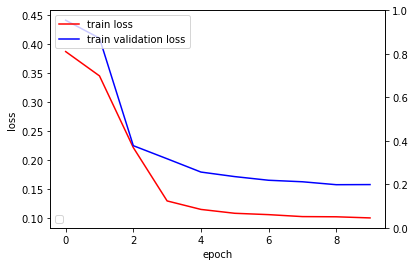

In [17]:
# 학습 과정 살펴보기 / watching train loss
print(history.history['loss'])
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'], 'r', label='train loss')
loss_ax.plot(history.history['val_loss'], 'b', label='train validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

In [18]:
model.evaluate(testX, testY)

172/172 [==============================] - 3s 15ms/step - loss: 0.1512 - mse: 0.0373


[0.15118150413036346, 0.03730307146906853]

In [19]:
# 예측
pred = model.predict(testX)

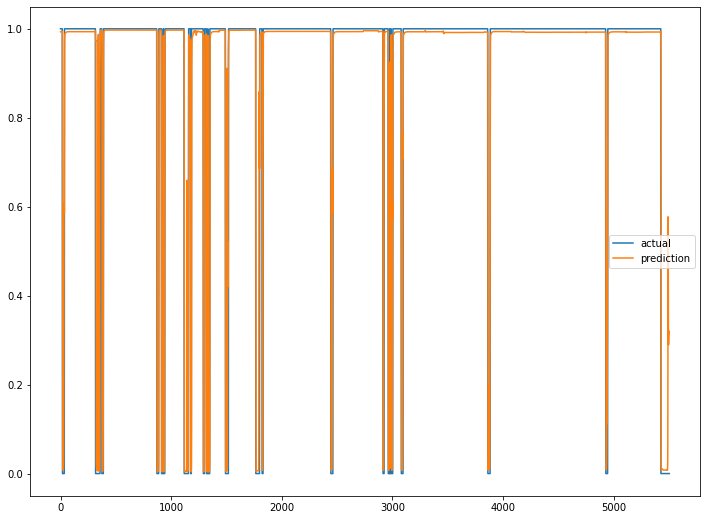

In [25]:
plt.figure(figsize=(12, 9))
plt.plot(testY[:,0], label='actual')
plt.plot(pred[:,0], label='prediction')

plt.legend()
#plt.xlim(300,500)
# plt.ylim(-0.1, 1.1)
plt.show()

In [21]:
1# def MAPE(y_true, y_pred): 
#     return np.abs((y_true - y_pred) / y_true) * 100

# plt.figure(figsize = (25,10))
# for i in range(0,12):
#     PRE = MAPE(testY[i:i+predict_length], pred[i:i+predict_length])
#     plt.plot(testX[i,:,-2], 'r', label='actual')
#     plt.plot(28,testY[i], 'gs', label='target')
#     plt.plot(28,test_predict[i], 'bo', label='pred')
#     plt.title('PRE = {}'.format(PRE))
#     plt.legend()

1